In [1]:
# 05_Model_Evaluation.ipynb

import pandas as pd
import numpy as np
import json
import os
import re
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- Konfigurasi Path (sesuaikan dengan struktur proyek Anda) ---
BASE_DRIVE_PATH = "/content/drive/MyDrive/Semester 6/PK/UAS" # Sesuaikan jika berbeda
PATH_EVAL_DATA = os.path.join(BASE_DRIVE_PATH, "data/eval")
PATH_RESULTS = os.path.join(BASE_DRIVE_PATH, "data/results")
PATH_PROCESSED_DATA = os.path.join(BASE_DRIVE_PATH, "data/processed")


# File input dari tahap-tahap sebelumnya
QUERIES_JSON_FILE = os.path.join(PATH_EVAL_DATA, "queries.json")
PREDICTIONS_CSV_FILE = os.path.join(PATH_RESULTS, "predictions.csv")

# File output untuk tahap ini
RETRIEVAL_METRICS_CSV = os.path.join(PATH_EVAL_DATA, "retrieval_metrics.csv")
PREDICTION_METRICS_CSV = os.path.join(PATH_EVAL_DATA, "prediction_metrics.csv")

In [4]:
# --- 1. Konfigurasi Path dan Pemuatan Data ---
print("--- TAHAP 5: EVALUASI MODEL ---")

# Konfigurasi Path (sesuaikan dengan struktur proyek Anda)
BASE_DRIVE_PATH = "/content/drive/MyDrive/Semester 6/PK/UAS" # Sesuaikan jika berbeda
PATH_EVAL_DATA = os.path.join(BASE_DRIVE_PATH, "data/eval")
PATH_RESULTS = os.path.join(BASE_DRIVE_PATH, "data/results")

# File input dari tahap-tahap sebelumnya
QUERIES_JSON_FILE = os.path.join(PATH_EVAL_DATA, "queries.json")
# Menggunakan file hasil perbandingan dari Tahap 4
PREDICTIONS_CSV_FILE = os.path.join(PATH_RESULTS, "predictions_comparison.csv")

# File output untuk tahap ini
RETRIEVAL_METRICS_CSV = os.path.join(PATH_EVAL_DATA, "retrieval_metrics.csv")
PREDICTION_METRICS_CSV = os.path.join(PATH_EVAL_DATA, "prediction_metrics.csv")

print("\nMemuat data ground truth dan hasil prediksi...")
try:
    with open(QUERIES_JSON_FILE, 'r', encoding='utf-8') as f:
        ground_truth_queries = json.load(f)
    df_ground_truth = pd.DataFrame(ground_truth_queries)
    print(f"Berhasil memuat {len(df_ground_truth)} queries dari {QUERIES_JSON_FILE}")
except FileNotFoundError:
    print(f"Error: File ground truth {QUERIES_JSON_FILE} tidak ditemukan.")
    exit()

try:
    df_predictions = pd.read_csv(PREDICTIONS_CSV_FILE)
    df_predictions['top_5_case_ids'] = df_predictions['top_5_case_ids'].apply(json.loads)
    print(f"Berhasil memuat {len(df_predictions)} hasil prediksi dari {PREDICTIONS_CSV_FILE}")
except FileNotFoundError:
    print(f"Error: File hasil prediksi {PREDICTIONS_CSV_FILE} tidak ditemukan. Pastikan Tahap 4 sudah dijalankan.")
    exit()

# Gabungkan ground truth dan hasil prediksi berdasarkan query_id
df_eval = pd.merge(df_ground_truth, df_predictions, on="query_id", how="left")
print("\nData gabungan untuk evaluasi:")
print(df_eval.head())

--- TAHAP 5: EVALUASI MODEL ---

Memuat data ground truth dan hasil prediksi...
Berhasil memuat 3 queries dari /content/drive/MyDrive/Semester 6/PK/UAS/data/eval/queries.json
Berhasil memuat 6 hasil prediksi dari /content/drive/MyDrive/Semester 6/PK/UAS/data/results/predictions_comparison.csv

Data gabungan untuk evaluasi:
  query_id                                         query_text  \
0     Q001  Suami meninggalkan istri dan anak lebih dari d...   
1     Q001  Suami meninggalkan istri dan anak lebih dari d...   
2     Q002  Terjadi perselisihan dan pertengkaran terus me...   
3     Q002  Terjadi perselisihan dan pertengkaran terus me...   
4     Q003           Salah satu pihak melakukan penganiayaan.   

                                   relevant_case_ids      correct_outcome  \
0             [2, 4, 10, 12, 14, 22, 23, 29, 34, 35]  MENGABULKAN GUGATAN   
1             [2, 4, 10, 12, 14, 22, 23, 29, 34, 35]  MENGABULKAN GUGATAN   
2  [1, 2, 3, 4, 7, 10, 12, 14, 21, 22, 23, 25, 29... 

In [5]:
# --- 2. Evaluasi Retrieval (Precision, Recall, F1-Score @k) ---
print("\n--- Mengevaluasi Kinerja Retrieval (BERT vs TF-IDF) ---")

def eval_retrieval(retrieved_ids, relevant_ids_ground_truth):
    """
    Menghitung metrik Precision@k, Recall@k, dan F1-Score@k untuk satu query.
    k adalah jumlah item yang di-retrieve (panjang dari retrieved_ids).
    """
    if not relevant_ids_ground_truth:
        return 0, 0, 0, 0

    retrieved_set = set(retrieved_ids)
    relevant_set = set(relevant_ids_ground_truth)
    true_positives = len(retrieved_set.intersection(relevant_set))

    k = len(retrieved_ids)
    precision = true_positives / k if k > 0 else 0
    total_relevant = len(relevant_set)
    recall = true_positives / total_relevant if total_relevant > 0 else 0

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    accuracy = 1 if true_positives > 0 else 0
    return precision, recall, f1, accuracy

retrieval_metrics = []
for index, row in df_eval.iterrows():
    # Pastikan 'relevant_case_ids' valid
    if not isinstance(row['relevant_case_ids'], list) or not row['relevant_case_ids']:
        continue

    precision_k, recall_k, f1_k, acc = eval_retrieval(row['top_5_case_ids'], row['relevant_case_ids'])
    retrieval_metrics.append({
        "query_id": row['query_id'],
        "retrieval_method": row['retrieval_method'],
        "precision_at_5": precision_k,
        "recall_at_5": recall_k,
        "f1_score_at_5": f1_k,
        "accuracy_at_5": acc
    })

df_retrieval_metrics = pd.DataFrame(retrieval_metrics)
print("\nMetrik Retrieval per Query per Model:")
print(df_retrieval_metrics)

# Hitung rata-rata metrik untuk perbandingan model
avg_retrieval_metrics = df_retrieval_metrics.groupby('retrieval_method').mean(numeric_only=True)
print("\nRata-rata Metrik Retrieval per Model (Macro Average):")
print(avg_retrieval_metrics)

# Simpan hasil metrik retrieval ke CSV
df_retrieval_metrics.to_csv(RETRIEVAL_METRICS_CSV, index=False)
print(f"\nMetrik retrieval disimpan ke: {RETRIEVAL_METRICS_CSV}")


--- Mengevaluasi Kinerja Retrieval (BERT vs TF-IDF) ---

Metrik Retrieval per Query per Model:
  query_id retrieval_method  precision_at_5  recall_at_5  f1_score_at_5  \
0     Q001             BERT             0.6     0.300000       0.400000   
1     Q001            TFIDF             1.0     0.500000       0.666667   
2     Q002             BERT             1.0     0.277778       0.434783   
3     Q002            TFIDF             1.0     0.277778       0.434783   
4     Q003             BERT             0.6     0.500000       0.545455   
5     Q003            TFIDF             0.8     0.666667       0.727273   

   accuracy_at_5  
0              1  
1              1  
2              1  
3              1  
4              1  
5              1  

Rata-rata Metrik Retrieval per Model (Macro Average):
                  precision_at_5  recall_at_5  f1_score_at_5  accuracy_at_5
retrieval_method                                                           
BERT                    0.733333     0

In [6]:
# --- 3. Evaluasi Prediksi Solusi (BERT vs TF-IDF) ---
print("\n--- Mengevaluasi Kinerja Prediksi Solusi ---")

# Pastikan kolom "correct_outcome" ada di ground truth
if 'correct_outcome' not in df_eval.columns:
    print("\nPeringatan: Kolom 'correct_outcome' tidak ditemukan di data ground truth.")
    print("Evaluasi prediksi solusi tidak dapat dilakukan.")
    print("Silakan tambahkan 'correct_outcome' ke file queries.json Anda dan jalankan ulang.")
else:
    prediction_metrics_list = []
    # Evaluasi untuk setiap metode retrieval
    for method in df_eval['retrieval_method'].unique():
        print(f"\n--- Hasil Prediksi untuk Metode: {method} ---")
        df_method = df_eval[df_eval['retrieval_method'] == method].dropna(subset=['correct_outcome', 'predicted_solution'])

        if not df_method.empty:
            y_true = df_method['correct_outcome']
            y_pred = df_method['predicted_solution']

            # Dapatkan semua label unik yang ada untuk laporan yang komprehensif
            all_labels = sorted(list(set(y_true) | set(y_pred)))

            print("\nClassification Report:")
            report = classification_report(y_true, y_pred, labels=all_labels, zero_division=0)
            print(report)

            # Hitung metrik agregat
            accuracy = accuracy_score(y_true, y_pred)
            f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0, labels=all_labels)

            prediction_metrics_list.append({
                "retrieval_method": method,
                "accuracy": accuracy,
                "f1_score_macro": f1_macro
            })
        else:
            print("Tidak ada data yang valid untuk evaluasi prediksi metode ini.")

    if prediction_metrics_list:
        df_prediction_metrics = pd.DataFrame(prediction_metrics_list)
        print("\nRingkasan Perbandingan Metrik Prediksi Solusi:")
        print(df_prediction_metrics)
        df_prediction_metrics.to_csv(PREDICTION_METRICS_CSV, index=False)
        print(f"\nMetrik prediksi solusi disimpan ke: {PREDICTION_METRICS_CSV}")


--- Mengevaluasi Kinerja Prediksi Solusi ---

--- Hasil Prediksi untuk Metode: BERT ---

Classification Report:
                     precision    recall  f1-score   support

          LAIN-LAIN       0.33      1.00      0.50         1
MENGABULKAN GUGATAN       0.00      0.00      0.00         2

           accuracy                           0.33         3
          macro avg       0.17      0.50      0.25         3
       weighted avg       0.11      0.33      0.17         3


--- Hasil Prediksi untuk Metode: TFIDF ---

Classification Report:
                     precision    recall  f1-score   support

          LAIN-LAIN       0.33      1.00      0.50         1
MENGABULKAN GUGATAN       0.00      0.00      0.00         2

           accuracy                           0.33         3
          macro avg       0.17      0.50      0.25         3
       weighted avg       0.11      0.33      0.17         3


Ringkasan Perbandingan Metrik Prediksi Solusi:
  retrieval_method  accuracy  f1_


--- Visualisasi & Analisis Kegagalan ---


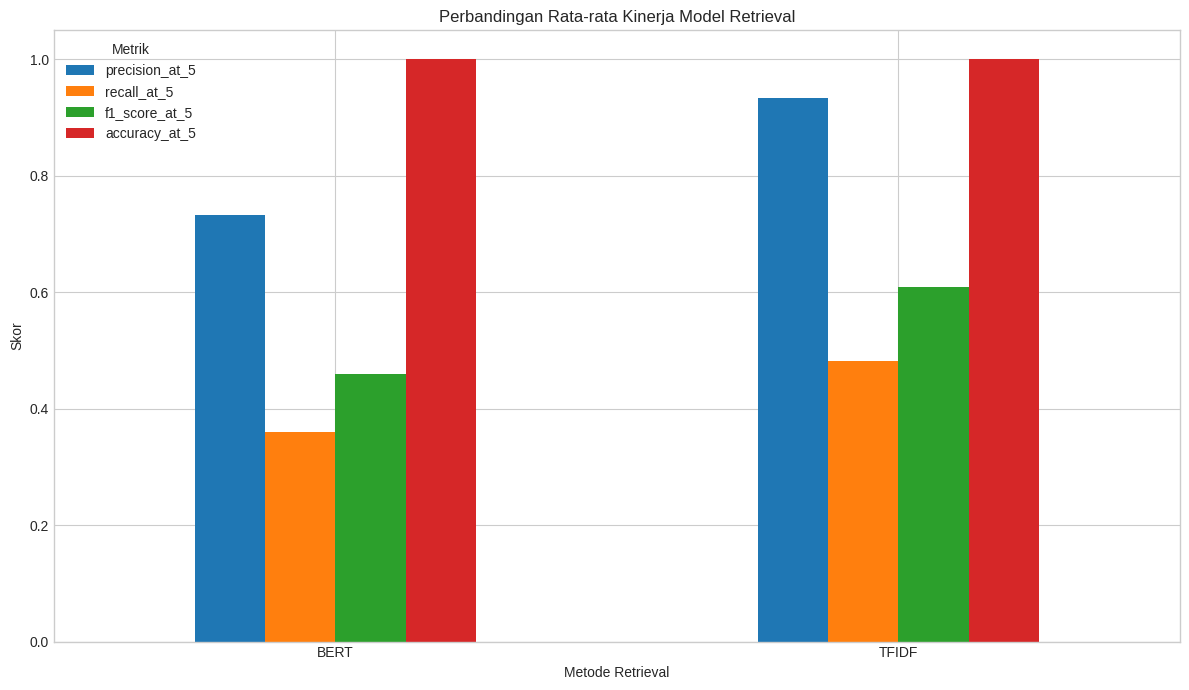


--- Tahap 5 Selesai ---


In [7]:
# --- 4. Visualisasi & Analisis Kegagalan ---
print("\n--- Visualisasi & Analisis Kegagalan ---")

# Visualisasi Perbandingan Kinerja Retrieval
if not avg_retrieval_metrics.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    avg_retrieval_metrics.plot(
        kind='bar',
        figsize=(12, 7),
        title='Perbandingan Rata-rata Kinerja Model Retrieval',
        ylabel='Skor',
        xlabel='Metode Retrieval',
        rot=0
    )
    plt.legend(title='Metrik')
    plt.tight_layout()
    plt.show()

print("\n--- Tahap 5 Selesai ---")